# Tank2 and Tank5 phase regulation

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
from sklearn.linear_model import LinearRegression
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [19]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

2.12.0


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear output layer.

We also test a model without input normalization layer.

In [20]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_len(norm, init_lr, numlabel):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(int(numlabel))
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_square(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model
def build_and_compile_model_nobatch(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), #200
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model


def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_LSTM(init_lr,numlabel):
  model = keras.Sequential([
      layers.LSTM(128, return_sequences=True),
      layers.LSTM(128),
      layers.Dense(int(numlabel))
  ])
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

## Define learning schedules and training

In [21]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [22]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=64, #30
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=64,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 0.5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [24]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['V5QSET','RFQ','Buncher']
    
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='seismic')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])

    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  

In [25]:
def plot_2dscatter_many(predictions,labels):

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5))
    if labels[0].shape[1] ==1:
        ax = [ax]

    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]

        for j in range(len(labels)):
            ax[i].scatter(labels[j].iloc[:,i], predictions[j][:,i], label='Data %d'%j)
            #ax[i].fill_between(labels[j].iloc[:,i],[np.min(predictions[j][k,i]) for k in ],np.max(predictions[j][:,i]),alpha=0.5)
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min([np.min(pred[:,i]) for pred in predictions]),np.min([np.min(lab.iloc[:,i]) for lab in labels])),
                max(np.max([np.max(pred[:,i]) for pred in predictions]),np.max([np.max(lab.iloc[:,i]) for lab in labels]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        #print(lims)
        ax[i].plot(lims, lims, color='b')
        ax[i].legend(ncol=2,fontsize=14, loc='upper left')
    fig.tight_layout()

In [26]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')    
    fig.tight_layout()

In [27]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5),sharey=False)
    fig.tight_layout()
    
    nbins=60
    if labels.shape[1]==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        error = [e for e in error if e <3*np.std(error)]

        ax[i].hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


In [28]:
def plot_1derror_many(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if i not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data')
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data')
        ax[i].set(title='%s'%key)
        #ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


## Define data loading functions

In [29]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    return subset

In [30]:
def fetch_reference(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
    return reference

In [31]:
def fetch_slice(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    sliced = dataset.loc[eval('&'.join(conds)).ravel()]
    return sliced

In [32]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [33]:
# List of approximate BPM positions in meters
dist_data = [26.5,27.0, 43.5, 44.0,60.8, 77.0,78.3,79.6,
            80.8, 82.5, 84.4,
            88.2, 90.1, 92.1,
            96.3, 98.4, 100.6, 102.8,
            105.0, 109.6, 111.9,
            114.7, 116.7, 119.1, 121.6,
            124.0, 126.5, 129.6, 131.6,
            134.2, 136.8, 139.4, 141.6]
#D42 : 107.3

## 2-phase models: T2, T5 setting

In [34]:
onedegdata = r"..\Data\untitled folder 2\devicescan_26042023.csv"
files =[r"..\Data\BS2\BEAM STUDY 14DEC2022\devicescan.csv", r"..\Data\BS1\BEAM STUDY 09OCT2022\devicescan_rfq_t2_t5.csv"]
cavs = ['L:RFQPAH','L:V2QSET','L:V5QSET']
#cavs = ['L:V2QSET','L:V5QSET']

path = ""
dfs = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs]) for f in files]

dfs = [df.drop(list(df.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1) for df in dfs]


# quality cuts 
dfs[0].iloc[0,:] = dfs[0].iloc[1,:]
dfs[0].iloc[99,:] = dfs[0].iloc[100,:]
dfs[0].iloc[297,:] = dfs[0].iloc[298,:]
dfs[0].iloc[1386,:] = dfs[0].iloc[1387,:]
dfs[0].iloc[1477,:] = dfs[0].iloc[1478,:]
dfs[0].iloc[1683,:] = dfs[0].iloc[1684,:]
dfs[0].iloc[1738,:] = dfs[0].iloc[1739,:]
dfs[0].iloc[2574,:] = dfs[0].iloc[2575,:]
dfs[0].iloc[2673,:] = dfs[0].iloc[2674,:]
dfs[0].iloc[2970,:] = dfs[0].iloc[2971,:]
dfs[0].iloc[3960,:] = dfs[0].iloc[3961,:]
dfs[0].iloc[3982,:] = dfs[0].iloc[3983,:]
dfs[0].iloc[4950,:] = dfs[0].iloc[4951,:]
dfs[0].iloc[5346,:] = dfs[0].iloc[5347,:]
dfs[0].iloc[5445,:] = dfs[0].iloc[5446,:]
dfs[0].iloc[5841,:] = dfs[0].iloc[5842,:]
dfs[0].iloc[5940,:] = dfs[0].iloc[5941,:]
dfs[0].iloc[6435,:] = dfs[0].iloc[6436,:]
dfs[0].iloc[6534,:] = dfs[0].iloc[6535,:]
dfs[0].iloc[7128,:] = dfs[0].iloc[7129,:]
dfs[0].iloc[7326,:] = dfs[0].iloc[7327,:]
dfs[0].iloc[7623,:] = dfs[0].iloc[7624,:]
dfs[0].iloc[7821,:] = dfs[0].iloc[7822,:]
dfs[0].iloc[8118,:] = dfs[0].iloc[8119,:]
dfs[0].iloc[8910,:] = dfs[0].iloc[8911,:]
dfs[0].iloc[9207,:] = dfs[0].iloc[9208,:]
dfs[0].iloc[9306,:] = dfs[0].iloc[9307,:]
dfs[0].iloc[9603,:] = dfs[0].iloc[9604,:]
dfs[0].iloc[9801,:] = dfs[0].iloc[9802,:]
dfs[0].iloc[10098,:] = dfs[0].iloc[10099,:]
dfs[0].iloc[10494,:] = dfs[0].iloc[10495,:]
dfs[0].iloc[10890,:] = dfs[0].iloc[10891,:]
dfs[0].iloc[10989,:] = dfs[0].iloc[10990,:]
dfs[0].iloc[11088,:] = dfs[0].iloc[11089,:]
dfs[0].iloc[11286,:] = dfs[0].iloc[11287,:]
dfs[0].iloc[11884,:] = dfs[0].iloc[11885,:]
dfs[0] = dfs[0].iloc[:-1,:]


dfs[0] = dfs[0].loc[(dfs[0]['L:BPM3OF']>0)& 
                    (dfs[0]['L:BPM4IF']>0) & (dfs[0]['L:BPM5IF']<-87) & (dfs[0]['L:D13BF']<-17.5)&
                    (dfs[0]['L:D41BF']<-150)& (dfs[0]['L:D52BF']<-44)& (dfs[0]['L:D72BF']<-65)]

dfs[1].iloc[0,:] = dfs[1].iloc[1,:]
dfs[1].iloc[5940] = dfs[1].iloc[5941]
dfs[1] = dfs[1].iloc[:-1,:]

meds = [[np.median(df[c]) for c in cavs] for df in dfs]
#print(meds)

stepsize = [[3.,0.5,0.3],[3.9,0.35,0.4]]

refs = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs,meds,stepsize)]
#print(refs)
ddfs = [df-ref for df,ref in zip(dfs,refs)]


df1deg = fetch_data('%s'%onedegdata,cavs[1:]+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs[1:]])
df1deg = df1deg.drop(list(df1deg.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1)
df1deg = df1deg.iloc[:-1,:]
df1deg['L:BPM5OF'] = df1deg['L:BPM5OF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D53BF'] = df1deg['L:D53BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D33BF'] = df1deg['L:D33BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D41BF'] = df1deg['L:D41BF'].apply(lambda x : x if x > 0 else x +360)
df1deg = df1deg.loc[(df1deg['L:D72BF']<-65) & (df1deg['L:BPM4IF']>95) & (df1deg['L:D23BF']<100)]

ref1deg =fetch_reference(df1deg,cavs[1:],[np.median(df1deg[c]) for c in cavs[1:]],[0.99,0.99])
ddf1deg = df1deg-ref1deg



In [35]:
ssdf = []
for i in range(3):
    cav = [c for c in cavs if c!=cavs[i]]
    ssdf.append([fetch_slice(df,cav,[0.,0.],[0.3,0.3]) for df in ddfs])
    #ssdf.append([fetch_slice(df,cav,[0.,0.],[0.9,0.9]) for df in ddfs])

ssdf =[[df.sort_index().reset_index(drop=True) for df in s] for s in ssdf]
ssdf = [[df.dropna() for df in s] for s in ssdf]

ssdf[0][1].drop([99],inplace=True)

print([[df.shape for df in s] for s in ssdf])

ssdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
#ssdfmed= [[df.groupby(np.arange(len(df))//10).mean() for df in s] for s in ssdf]
print([[df.shape for df in s] for s in ssdfmed])

[[(99, 35), (99, 35)], [(98, 35), (99, 35)], [(98, 35), (99, 35)]]
[[(11, 35), (11, 35)], [(11, 35), (11, 35)], [(11, 35), (11, 35)]]


In [36]:
ssdfmed[1][0].head(60)

,L:RFQPAH,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,0.0,-3.000000,0.0,-6.429443,-4.682617,-5.571289,4.533691,-2.545776,-0.988159,0.040283,...,2.155762,2.317505,1.791382,0.465698,-1.019287,-2.233276,-2.539673,-2.516479,-2.614746,-2.205811
1,0.0,-2.400000,0.0,-5.067139,-3.715820,-4.230957,3.566895,-1.809692,-0.515747,0.155640,...,1.754761,2.026367,1.143188,0.075684,-1.074219,-1.815796,-1.924438,-1.736450,-1.680908,-1.409302
2,0.0,-1.799999,0.0,-3.715820,-2.716064,-3.176270,2.473755,-1.447144,-0.515747,-0.047607,...,1.249390,1.647339,0.961914,0.125122,-0.794067,-1.288452,-1.479492,-1.220093,-1.323853,-1.030273
3,0.0,-1.200001,0.0,-2.490845,-1.892090,-2.127075,1.627808,-0.551758,-0.015869,0.353394,...,0.881348,0.768433,0.313721,-0.204468,-0.574341,-0.783081,-0.754395,-0.522461,-0.461426,-0.189819
4,0.0,-0.600000,0.0,-1.293335,-1.084595,-1.033936,0.529175,0.206299,0.396118,0.474243,...,0.244141,0.147705,-0.010376,-0.204468,-0.167847,-0.178833,-0.150146,-0.044556,-0.016479,0.216675
5,0.0,0.000000,0.0,0.036011,0.046997,0.009766,-0.042114,-0.002441,0.028076,-0.031128,...,-0.008545,-0.077515,-0.048828,-0.078125,-0.008545,0.035400,0.053101,0.070801,0.104370,0.018921
6,0.0,0.600000,0.0,0.805054,0.601807,0.844727,-1.124268,0.788574,0.494995,0.358887,...,-0.426025,-0.148926,-0.378418,-0.215454,0.205688,0.381470,0.520020,0.587158,0.543823,0.562744
7,0.0,1.200001,0.0,2.260742,1.618042,1.915894,-2.080078,2.084961,1.264038,0.617065,...,-0.997314,-1.049805,-0.905762,-0.286865,0.271606,0.919800,1.289062,1.510010,1.516113,1.507568
8,0.0,1.799999,0.0,3.573608,2.579346,2.932129,-2.931519,2.024536,1.209106,0.336914,...,-1.008301,-1.346436,-1.004639,-0.374756,0.375977,0.941772,1.404419,1.570435,1.763306,1.826172
9,0.0,2.400000,0.0,4.699707,3.320923,3.882446,-3.706055,3.244019,1.989136,0.869751,...,-1.755371,-1.588135,-1.427612,-0.380249,0.661621,1.721802,2.162476,2.465820,2.515869,2.534790


6 11


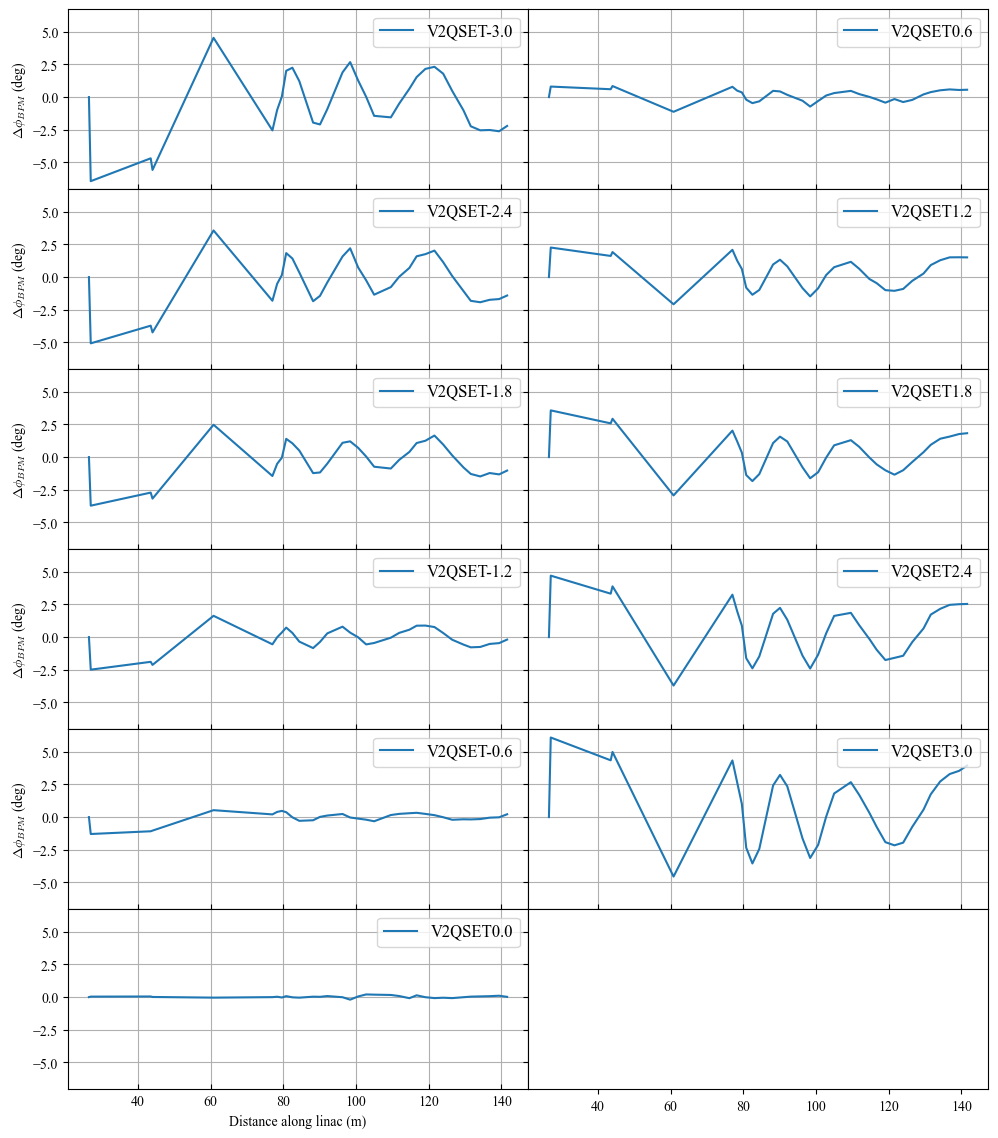

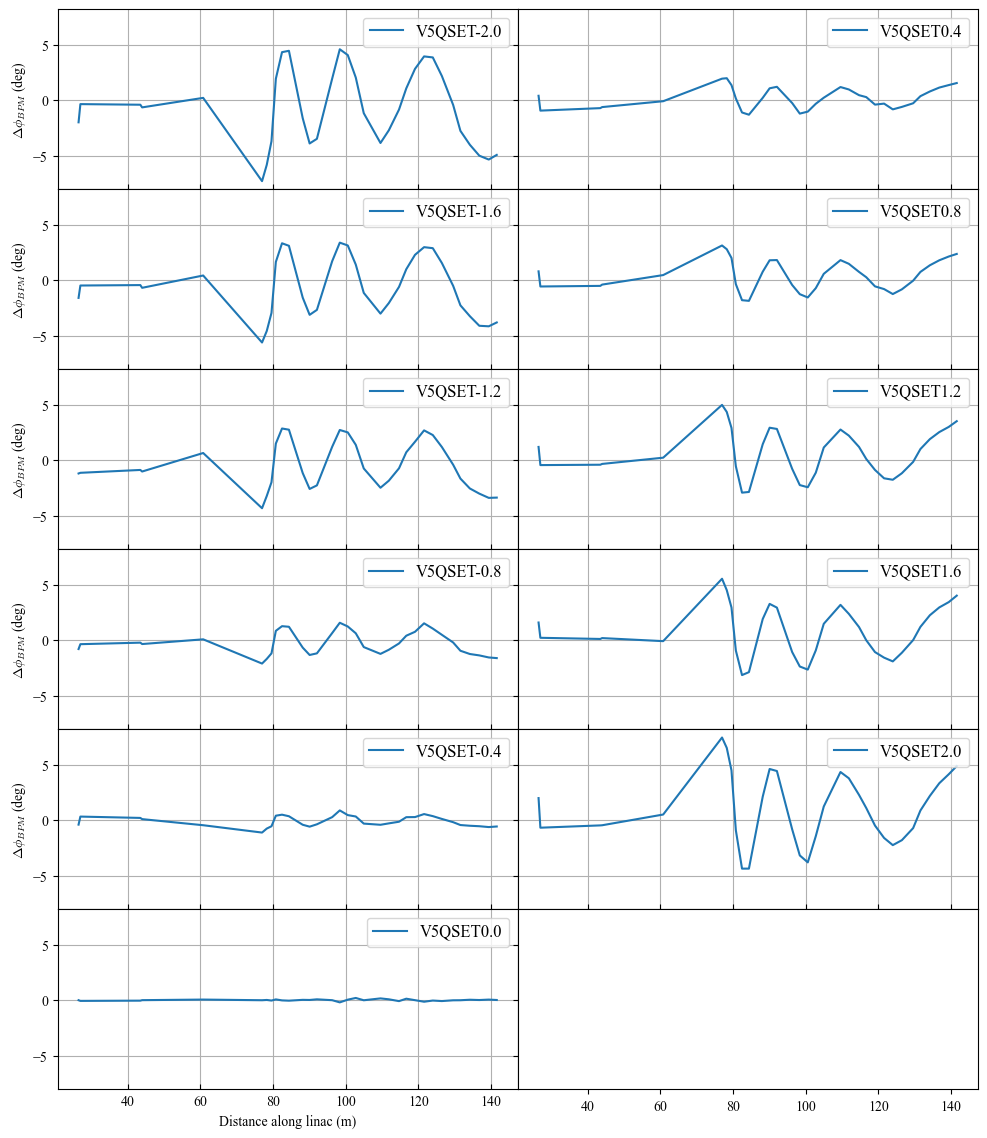

In [37]:
%matplotlib inline

nplots = ssdfmed[0][0].shape[0]
nrows = int(nplots/2) if nplots%2==0 else int(nplots/2)+1
print(nrows, nplots)
#devs = ['RFQPAH','V2QSET','V5QSET']
devs = ['test', 'V2QSET','V5QSET']
for i in (1, 2):
    fig, axs = plt.subplots(nrows,2, figsize=(10,12), sharex=True, sharey=True)
    for k in range(nplots):
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][0].iloc[k,2:], label='%s%.1f'%(devs[i],ssdfmed[i][0].iloc[k,i]), marker='',linestyle='-')
        #axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][1].iloc[k,3:-2], label='%s%.1f'%(devs[i],ssdfmed[i][1].iloc[k,0]), marker='o',linestyle='-')

        axs[int(k%(nplots/2))][int(k*2/(nplots))].legend(loc='upper right', fancybox=True, fontsize='large')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].xaxis.set_tick_params(direction='in', which='major')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].grid(True)
        #axs[int(k%(nplots/2))][int(k*2/(nplots))].set_ylim(-4.,5)
        if int(k%(nplots/2))==nrows-1:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(xlabel='Distance along linac (m)')
        elif int(k/(nplots/2))%2==0:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(ylabel='$\Delta \phi_{BPM}$ (deg)')
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.05)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.06)
    plt.subplots_adjust(right=0.98)

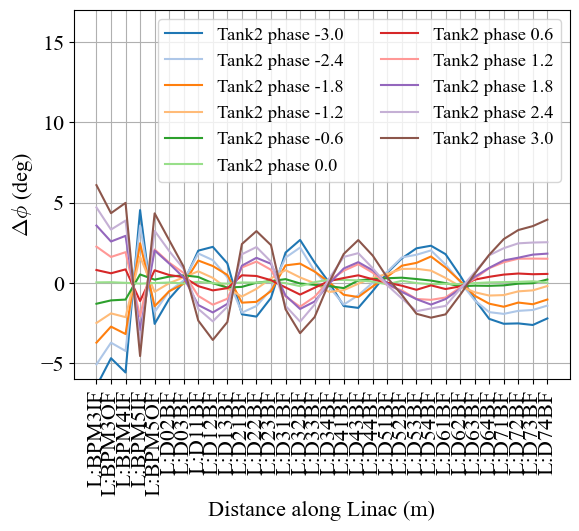

In [70]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
[plt.plot(ssdfmed[1][0].iloc[k,3:], label='Tank2 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed[1][0].iloc[k,2:], label='Tank5 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.ylim(-6, 17)
plt.xticks(rotation = 90);

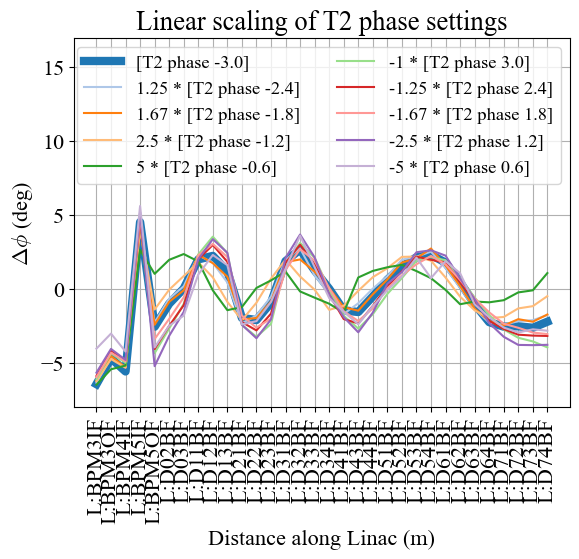

In [71]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
#[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed[2][0].iloc[k,3:], label='Tank5 phase %2.1f'%(ssdfmed[2][0].iloc[k,2]), marker='',linestyle='-') for k in range(11) ]

plt.plot(ssdfmed[1][0].iloc[0,3:], label='[T2 phase %2.1f]'%(ssdfmed[1][0].iloc[0,1]), marker='',linestyle='-', linewidth = 6)
plt.plot(3/2.4 * ssdfmed[1][0].iloc[1,3:], label='1.25 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[1,1]), marker='',linestyle='-')
plt.plot(3/1.8 * ssdfmed[1][0].iloc[2,3:], label='1.67 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[2,1]), marker='',linestyle='-')
plt.plot(3/1.2 * ssdfmed[1][0].iloc[3,3:], label='2.5 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[3,1]), marker='',linestyle='-')
plt.plot(3/0.6 * ssdfmed[1][0].iloc[4,3:], label='5 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[4,1]), marker='',linestyle='-')

plt.plot(-ssdfmed[1][0].iloc[10,3:], label='-1 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[10,1]), marker='',linestyle='-')
plt.plot(-1.25 * ssdfmed[1][0].iloc[9,3:], label='-1.25 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[9,1]), marker='',linestyle='-')
plt.plot(-2/1.2 * ssdfmed[1][0].iloc[8,3:], label='-1.67 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[8,1]), marker='',linestyle='-')
plt.plot(-2.5 * ssdfmed[1][0].iloc[7,3:], label='-2.5 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[7,1]), marker='',linestyle='-')
plt.plot(-5 * ssdfmed[1][0].iloc[6,3:], label='-5 * [T2 phase %2.1f]'%(ssdfmed[1][0].iloc[6,1]), marker='',linestyle='-')


plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.title("Linear scaling of T2 phase settings")
plt.ylim(-8, 17)
plt.xticks(rotation = 90);

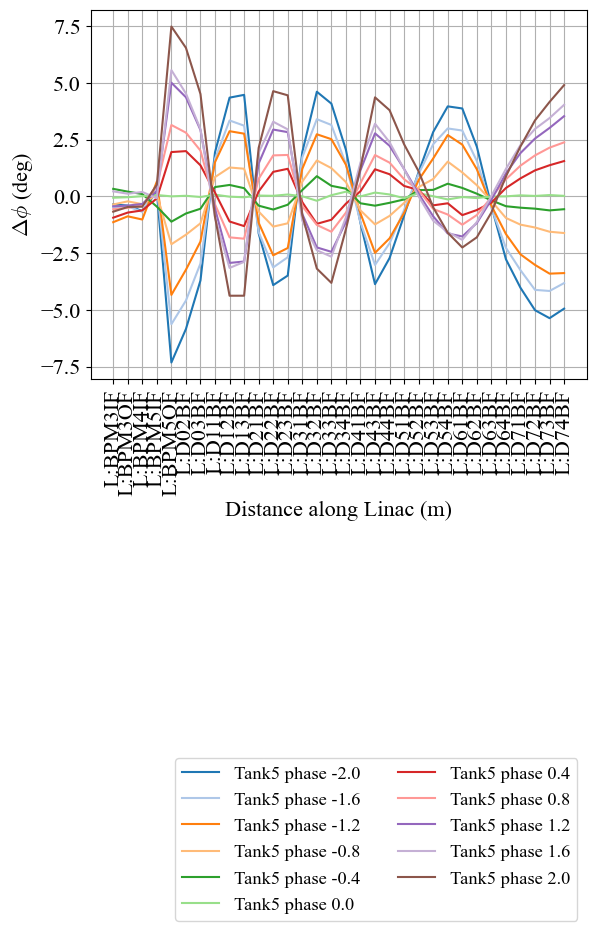

In [39]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
#[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
[plt.plot(ssdfmed[2][0].iloc[k,3:], label='Tank5 phase %2.1f'%(ssdfmed[2][0].iloc[k,2]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2, bbox_to_anchor = (1, -1))
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);

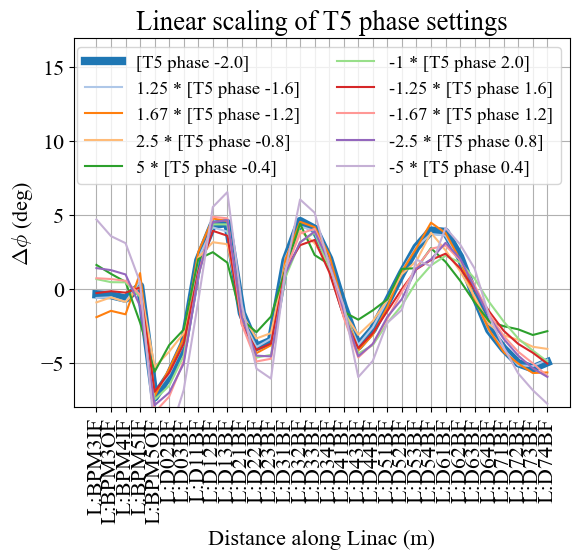

In [68]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
#[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed[2][0].iloc[k,3:], label='Tank5 phase %2.1f'%(ssdfmed[2][0].iloc[k,2]), marker='',linestyle='-') for k in range(11) ]

plt.plot(ssdfmed[2][0].iloc[0,3:], label='[T5 phase %2.1f]'%(ssdfmed[2][0].iloc[0,2]), marker='',linestyle='-', linewidth = 6)
plt.plot(1.25 * ssdfmed[2][0].iloc[1,3:], label='1.25 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[1,2]), marker='',linestyle='-')
plt.plot(2/1.2 * ssdfmed[2][0].iloc[2,3:], label='1.67 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[2,2]), marker='',linestyle='-')
plt.plot(2.5 * ssdfmed[2][0].iloc[3,3:], label='2.5 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[3,2]), marker='',linestyle='-')
plt.plot(5 * ssdfmed[2][0].iloc[4,3:], label='5 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[4,2]), marker='',linestyle='-')

plt.plot(-ssdfmed[2][0].iloc[10,3:], label='-1 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[10,2]), marker='',linestyle='-')
plt.plot(-1.25 * ssdfmed[2][0].iloc[9,3:], label='-1.25 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[9,2]), marker='',linestyle='-')
plt.plot(-2/1.2 * ssdfmed[2][0].iloc[8,3:], label='-1.67 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[8,2]), marker='',linestyle='-')
plt.plot(-2.5 * ssdfmed[2][0].iloc[7,3:], label='-2.5 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[7,2]), marker='',linestyle='-')
plt.plot(-5 * ssdfmed[2][0].iloc[6,3:], label='-5 * [T5 phase %2.1f]'%(ssdfmed[2][0].iloc[6,2]), marker='',linestyle='-')


plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.title("Linear scaling of T5 phase settings")
plt.ylim(-8, 17)
plt.xticks(rotation = 90);

In [40]:
def linear_estimator(data, b_vec_1, b_vec_2):
    vec1 = ssdfmed[1][0].iloc[b_vec_1, 3:]
    vec2 = ssdfmed[2][0].iloc[b_vec_2, 3:]
    
    X = np.column_stack((vec1, vec2))
    model = LinearRegression()
    model.fit(X, data)
    
    return model.coef_

def error_calculator(data, b_vec_1, b_vec_2):
    vec1 = ssdfmed[1][0].iloc[b_vec_1, 3:]
    vec2 = ssdfmed[2][0].iloc[b_vec_2, 3:]
    coeffs = linear_estimator(data, b_vec_1, b_vec_2)
    best_fit = (vec1 * coeffs[0] + vec2 * coeffs[1])[5:]
    diff = np.diff(np.array([best_fit, np.array(data)[5:]]), axis=0)
    return np.sum(diff**2)
    
    

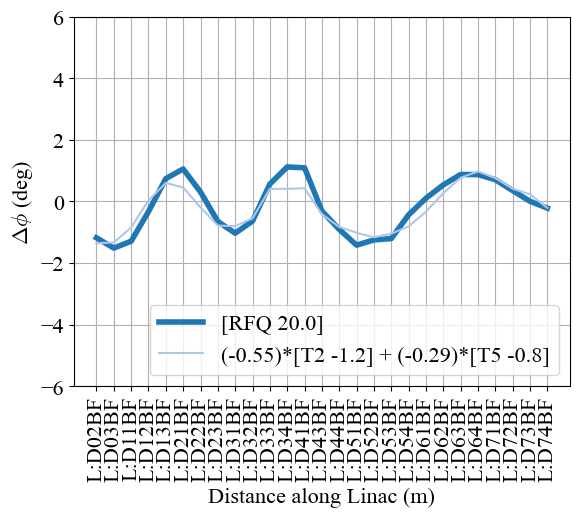

In [41]:
k2 = 10

test_ar = ssdfmed[0][0].iloc[k2, 3:]

coefficients = linear_estimator(test_ar, 0, -1)

plt.plot(test_ar[5:], label = '[RFQ %.1f]'%(ssdfmed[0][0].iloc[k2, 0]), linewidth = 4)
plt.plot((ssdfmed[1][0].iloc[0, 3:] * coefficients[0] + ssdfmed[2][0].iloc[-1, 3:] * coefficients[1])[5:], label = '(%.2f)*[T2 -1.2] + (%.2f)*[T5 -0.8]'%tuple(coefficients))
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);
plt.legend(loc = 'lower right')
plt.ylim(-6, 6)
plt.grid()
plt.show()

2.229915855106246


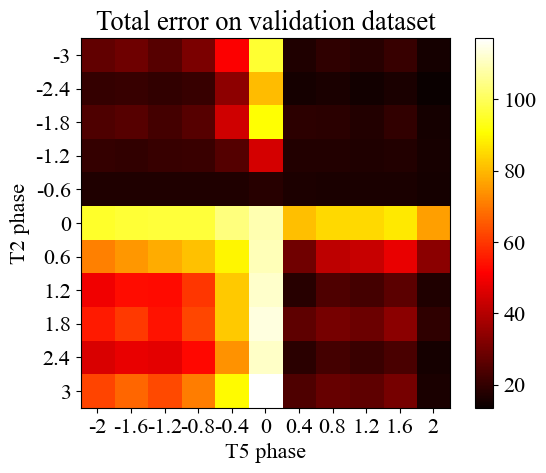

array([[ 27.214,  29.159,  25.661,  31.063,  51.146,  95.795,  17.171,
         19.287,  18.235,  20.627,  15.263],
       [ 20.285,  20.786,  19.733,  20.495,  33.935,  80.482,  15.5  ,
         16.394,  14.784,  16.368,  13.565],
       [ 24.478,  25.553,  22.564,  25.543,  44.201,  90.939,  19.124,
         18.74 ,  17.431,  19.702,  15.351],
       [ 20.176,  19.874,  20.798,  20.931,  25.125,  44.838,  17.232,
         17.209,  16.856,  17.376,  15.927],
       [ 16.915,  16.957,  16.862,  16.904,  17.16 ,  18.08 ,  16.512,
         16.205,  16.191,  16.184,  15.542],
       [ 95.163,  96.264,  96.66 ,  96.763, 103.683, 109.008,  80.906,
         84.809,  84.773,  87.519,  76.163],
       [ 71.191,  74.864,  78.137,  81.144,  89.575, 109.748,  29.726,
         41.386,  42.72 ,  48.273,  33.493],
       [ 49.545,  53.295,  53.061,  59.715,  82.485, 111.823,  18.355,
         24.153,  22.598,  26.461,  17.098],
       [ 55.411,  60.293,  54.316,  62.183,  82.679, 113.861,  26.544,
 

In [42]:
print(error_calculator(test_ar, 3, 3))

chi_sq_ar = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        for k in range(11):
            chi_sq_ar[i, j] += error_calculator(ssdfmed[0][0].iloc[k, 3:], i, j)
        
plt.imshow(chi_sq_ar, cmap = 'hot')
plt.colorbar()
plt.title('Total error on validation dataset')
plt.ylabel('T2 phase')
plt.yticks(np.arange(11), (-3, -2.4, -1.8, -1.2, -0.6, 0, 0.6, 1.2, 1.8, 2.4, 3))
plt.xlabel('T5 phase')
plt.xticks(np.arange(11), (-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2))
plt.show()
chi_sq_ar

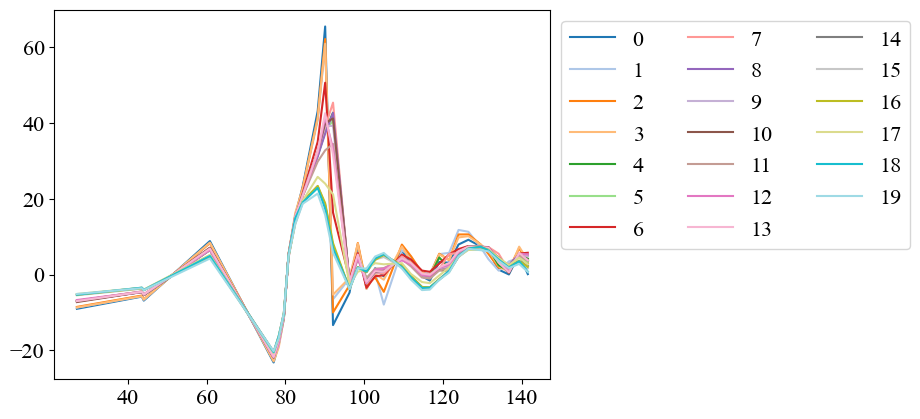

In [43]:
for i in range(20):
    plt.plot(dist_data[1:], ddf1deg.iloc[i, 2:], label = str(i))
plt.legend(ncols = 3, bbox_to_anchor = (1, 1))
plt.show()

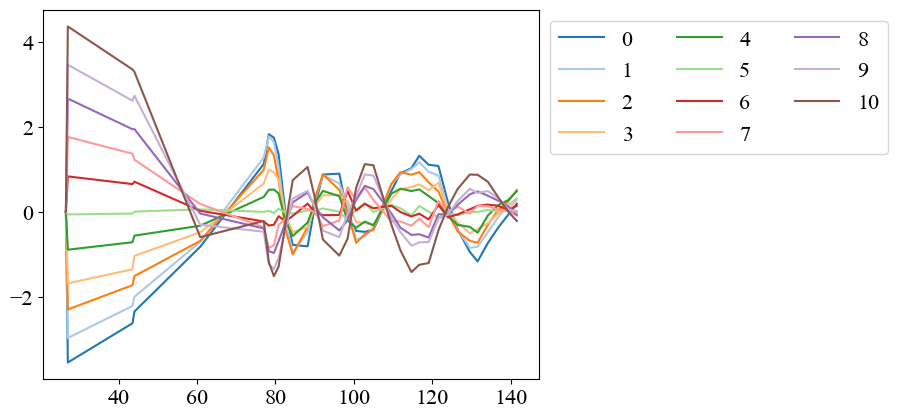

In [44]:
for i in range(11):
    plt.plot(dist_data, ssdfmed[0][0].iloc[i, 2:], label = str(i))
plt.legend(ncols = 3, bbox_to_anchor = (1, 1))
plt.show()

In [45]:
ssdfmed[0][0]

,L:RFQPAH,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,-19.995117,0.0,0.0,-3.545532,-2.622681,-2.346802,-0.822144,1.123657,1.824341,1.743164,...,1.106567,1.076050,0.231323,-0.413208,-0.942383,-1.167603,-0.737915,-0.379639,-0.071411,0.189209
1,-15.997314,0.0,0.0,-2.968750,-2.216187,-2.000732,-0.706787,1.277466,1.774902,1.638794,...,0.941772,0.850830,0.083008,-0.424194,-0.848999,-0.821533,-0.485229,-0.137939,0.159302,0.315552
2,-11.999512,0.0,0.0,-2.298584,-1.727295,-1.511841,-0.684814,0.986328,1.516724,1.325684,...,0.694580,0.477295,-0.037842,-0.462646,-0.684204,-0.728149,-0.309448,0.037842,0.241699,0.507812
3,-7.995605,0.0,0.0,-1.683350,-1.353760,-1.039429,-0.481567,0.662231,0.994873,0.919189,...,0.507812,0.680542,0.044556,-0.248413,-0.508423,-0.409546,-0.270996,-0.044556,0.065918,0.282593
4,-3.997803,0.0,0.0,-0.892334,-0.716553,-0.561523,-0.327759,0.349121,0.516968,0.523682,...,0.370483,0.202637,-0.103760,-0.308838,-0.354614,-0.491943,-0.089722,0.153198,0.274658,0.485840
5,0.000000,0.0,0.0,-0.062866,-0.040894,0.004272,0.056763,-0.002441,0.022583,-0.031128,...,0.002441,-0.137939,-0.032349,-0.078125,-0.008545,-0.003052,0.042114,0.015869,0.054932,0.018921
6,4.003906,0.0,0.0,0.832520,0.651245,0.707397,0.023804,-0.227661,-0.323486,-0.305786,...,-0.178833,0.158691,-0.131226,-0.061646,0.057373,0.139771,0.168457,0.142212,0.038452,0.139771
7,8.001709,0.0,0.0,1.760864,1.365356,1.223755,0.183105,-0.364990,-0.850830,-0.789185,...,-0.360107,0.252075,0.006104,0.119629,-0.041504,0.139771,0.130005,0.054321,0.010986,-0.090942
8,12.005615,0.0,0.0,2.661743,1.942139,1.943359,-0.042114,-0.392456,-0.927734,-0.970459,...,-0.607300,-0.055542,-0.065308,0.163574,0.408936,0.480347,0.377197,0.263062,0.126343,-0.068970
9,16.003418,0.0,0.0,3.458252,2.612305,2.728882,-0.305786,-0.469360,-1.235352,-1.349487,...,-0.711670,-0.159912,-0.070801,0.251465,0.540771,0.441895,0.487061,0.323486,0.060425,-0.008545


In [ ]:
plt.scatter(dist_data, 2*ssdfmed[0][0].iloc[0][2:])
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);
plt.ylim(-20, 20)
plt.grid()
plt.show()

# Simulation Import and testing

In [ ]:
from Import_files import linacSIM as simulation
import itertools

In [ ]:
init_energy = 0.75e06 #MeV                                                                                                                                          
init_phase = -32 #deg                                                                                                                                        
synch_phase=-32.0

rP = [20] #delta phi in degrees, can take multiple entries                                                                                        
rE = [0.001e6] #delta E in MeV, can take multiple                                                                                                      
n = [1, 2, 3] # number of particles on circle, can take multiple                                                                                          

oneparticle = simulation.generate_part_gauss(init_energy,init_phase,synch_phase,simulation.rf_freq_L,rP,rE,n,vis=False)


particle=simulation.propagate_many_fromT1(simulation.df,oneparticle)
simulation.plot_all_osc(particle,-1)

In [ ]:
init_energy = 92.552e6#0.75e06 #MeV                                                                                                                                          
init_phase = -32 #deg                                                                                                                                        

rP = [2] #delta phi in degrees, can take multiple entries                                                                                         
rE = [0.001e6] #delta E in MeV, can take multiple                                                                                                       
n = [3] # number of particles on circle, can take multiple                                                                                          


#test = generate_part_circle(init_energy,init_phase,synch_phase,rf_freq_L,rP,rE,n,vis=True)
test = simulation.generate_part_gauss(init_energy,init_phase,synch_phase,simulation.rf_freq_L,rP,rE,n,vis=False)
#test = generate_part_synch(init_energy,synch_phase,n,vis=False)
test
partdfs=simulation.propagate_many_fromT5(simulation.df2,test)
simulation.plot_all_osc(partdfs,-1)

In [ ]:
## Propagate synchronous particle with different dPhi at T2 and T5

init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase-20 ##CHANGED
    
#Last LE turn
last_LE_cell = len(simulation.df_L)-1
  
#a = np.arange(-5,5.1,1)
#b = np.arange(-5,5.1,1)
a = np.linspace(-2,2,11)
b = np.linspace(-2,2,11)
c = np.arange(-20,20.1,4)

cells=[0]
RFdict = [dict(zip(cells,c[i])) for i in range(len(c))]

print(RFdict)
T2T5scan = []

for rfd in RFdict:
    testtest = simulation.propagate_RFkick(simulation.df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              simulation.rf_freq_L,simulation.rf_freq_H,last_LE_cell,rfd)   

    T2T5scan.append(testtest)


In [ ]:
#print(c)
idx1 = c.index((0,0))
idx2 = c.index((0,-2))
print(idx1,idx2)
#plot_all_osc(,1)

simulation.plot_phase_osc_select(T2T5scan,[idx1,idx2])

In [ ]:
init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase+0
    
#Last LE turn
last_LE_cell = len(simulation.df_L)-1

c = np.arange(-15,15,1)
cells=[0]

RFdict = [dict(zip(cells,[c])) for c in c]

print(RFdict)
T0scan = []

for rfd in RFdict:
    testtest = simulation.propagate_RFkick(simulation.df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              simulation.rf_freq_L,simulation.rf_freq_H,last_LE_cell,rfd)   
    T0scan.append(testtest)


In [ ]:
init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase+0
    
#Last LE turn
last_LE_cell = len(simulation.df_L)-1

#c = np.arange(-15,15,1)
c = [-12,12]
cells=[0]

RFdict = [dict(zip(cells,[c])) for c in c]

print(RFdict)
T0 = []

for rfd in RFdict:
    testtest = simulation.propagate_RFkick(simulation.df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              simulation.rf_freq_L,simulation.rf_freq_H,last_LE_cell,rfd)   
    T0.append(testtest)


In [ ]:
simulation.plot_phase_osc(T0, 1)

In [ ]:
#plot_emittance(T0scan,207)
#%matplotlib widget
plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf',
                    'axes.labelsize': 'xx-large',
                    'axes.titlesize':'xx-large',
                    'xtick.labelsize':'xx-large',
                    'ytick.labelsize':'xx-large',})


[plt.scatter(simulation.df['dPhi'].iloc[206],simulation.df['dE'].iloc[206],color='b') for df in T2T5scan];
#[plt.scatter(df['dPhi'].iloc[206],df['dE'].iloc[206],color='r') for df in T0scan];

plt.xlabel('$\Delta\phi_{out}$ (deg)')
plt.ylabel('$\Delta E_{out}$ (eV)')


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((7,8)) 
plt.gca().yaxis.set_major_formatter(formatter) 

#plt.gca().yaxis.get_major_formatter().set_scientific(True)
plt.xlim(-7.5,7.5)
plt.ylim(-250000,250000)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(left=0.24)
plt.subplots_adjust(right=0.96)  
plt.grid()